# Sistema de Análise de Ondas de Calor em Python
Desenvolva um sistema que identifica e analisa ondas de calor usando dados históricos de temperatura. O código deve:
- Detectar períodos onde a temperatura máxima excede o percentil 90 por 3+ dias consecutivos
- Calcular intensidade, duração e frequência das ondas de calor
- Gerar mapas de calor temporal, gráficos de tendências decadais e relatórios de impacto climático
- Implementar algoritmos de detecção baseados em índices como HWMId (Heat Wave Magnitude Index daily)

## Importação das bibliotecas

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import calendar
from datetime import datetime, timedelta


## Configurações iniciais

In [15]:
plt.style.use('ggplot')
sns.set_palette("YlOrRd")

## Desenvolvimento da classe


Relatório Climático:
Total de ondas de calor detectadas: 47
Duração média: 3.8 dias
Intensidade média: 10.0 °C acumulados
Magnitude média (HWMId): 10.0


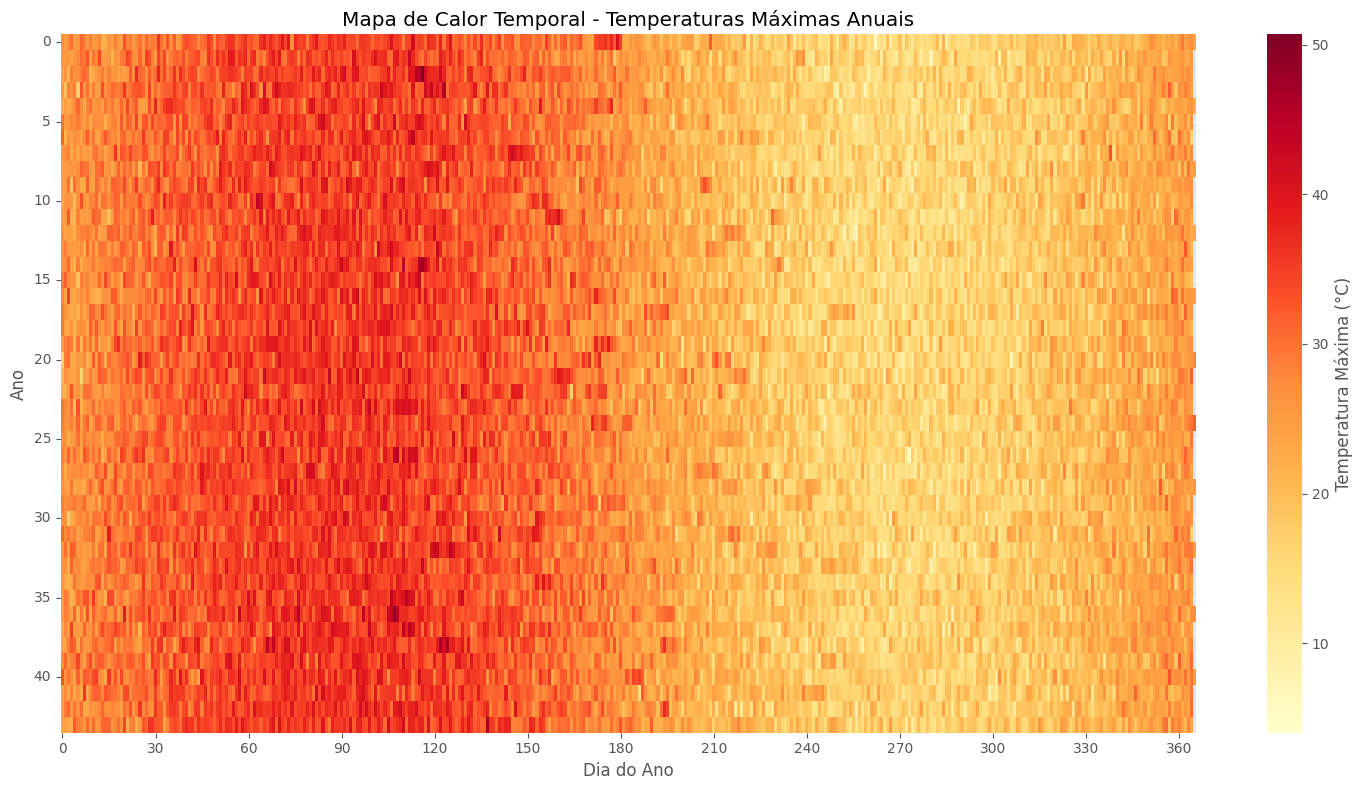

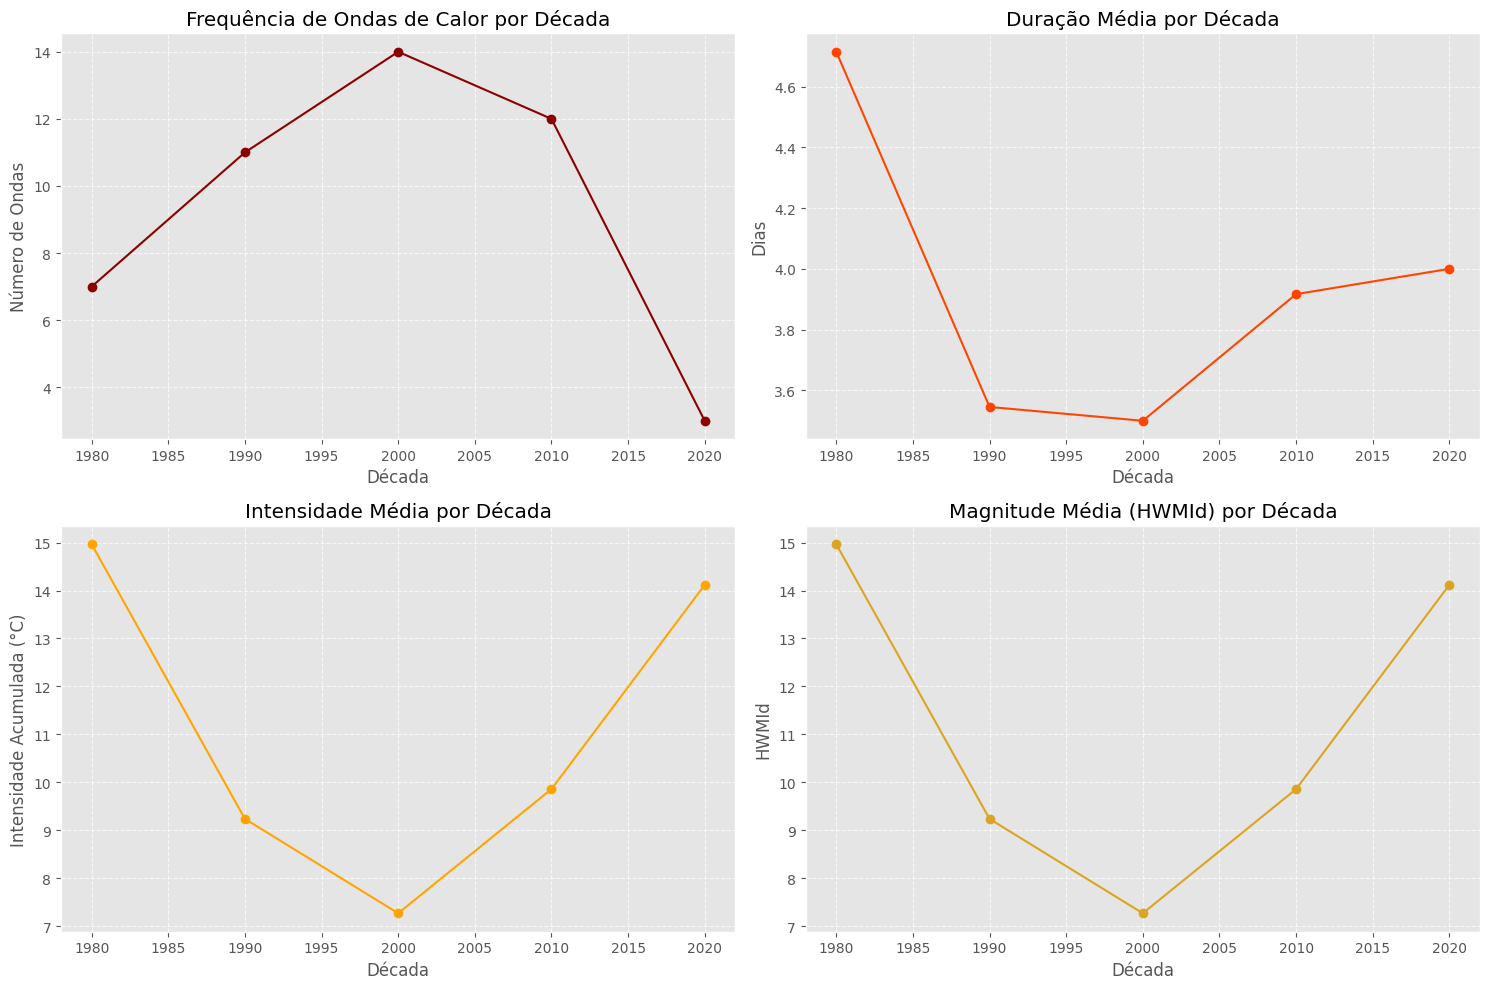

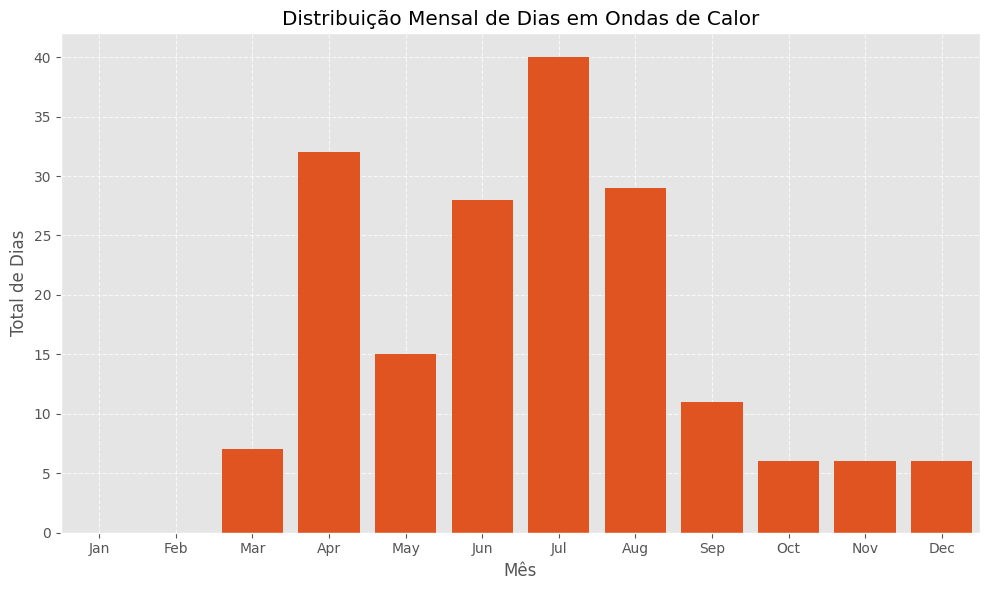


Exemplo de ondas de calor detectadas:
  start_date   end_date  duration   max_temp  mean_temp  intensity      hwmid  \
0 1980-06-21 1980-06-29         9  41.192398  35.517982  34.049450  34.049450   
1 1981-08-26 1981-08-28         3  26.863926  24.975936   8.522386   8.522386   
2 1982-04-25 1982-04-28         4  50.689586  45.307971  22.986400  22.986400   
3 1985-04-25 1985-04-27         3  41.595323  40.321329   2.244727   2.244727   
4 1987-05-25 1987-05-31         7  42.444326  38.518017  17.350254  17.350254   

   year  decade  
0  1980    1980  
1  1981    1980  
2  1982    1980  
3  1985    1980  
4  1987    1980  


In [19]:
class HeatWaveAnalyzer:
    def __init__(self, temp_data, threshold_percentile=90, min_consecutive_days=3):
        """
        Inicializa o analisador de ondas de calor.
        
        Args:
            temp_data (DataFrame): Dados de temperatura com colunas 'date' e 'temp_max'
            threshold_percentile (int): Percentil para definir o limiar de onda de calor (padrão: 90)
            min_consecutive_days (int): Mínimo de dias consecutivos para considerar onda de calor (padrão: 3)
        """
        self.data = temp_data.copy()
        self.threshold_percentile = threshold_percentile
        self.min_consecutive_days = min_consecutive_days
        self.heat_waves = None
        self.climate_report = None
        
        # Pré-processamento
        self._preprocess_data()
        
    def _preprocess_data(self):
        """Prepara os dados para análise."""
        # Garante que a data está no formato correto
        self.data['date'] = pd.to_datetime(self.data['date'])
        self.data = self.data.sort_values('date').reset_index(drop=True)
        
        # Adiciona colunas auxiliares
        self.data['year'] = self.data['date'].dt.year
        self.data['month'] = self.data['date'].dt.month
        self.data['day'] = self.data['date'].dt.day
        self.data['doy'] = self.data['date'].dt.dayofyear  # dia do ano
        
        # Calcula o limiar de temperatura para cada dia do ano (percentil móvel)
        self._calculate_thresholds()
        
    def _calculate_thresholds(self, window_size=15):
        """
        Calcula o limiar de temperatura para cada dia do ano usando uma janela móvel.
        
        Args:
            window_size (int): Tamanho da janela em dias para calcular o percentil (padrão: 15)
        """
        thresholds = []
        
        for doy in range(1, 367):  # para cada dia do ano
            # Define a janela ao redor do dia do ano (considerando anos bissextos)
            window_start = max(1, doy - window_size)
            window_end = min(366, doy + window_size)
            
            # Filtra os dados na janela
            window_data = self.data[
                (self.data['doy'] >= window_start) & 
                (self.data['doy'] <= window_end)
            ]['temp_max']
            
            if not window_data.empty:
                threshold = np.percentile(window_data, self.threshold_percentile)
                thresholds.append(threshold)
            else:
                thresholds.append(np.nan)
        
        # Cria um DataFrame com os limiares por dia do ano
        self.threshold_df = pd.DataFrame({
            'doy': range(1, 367),
            'threshold': thresholds
        })
        
        # Merge com os dados originais
        self.data = self.data.merge(self.threshold_df, on='doy', how='left')
        
    def detect_heat_waves(self):
        """Detecta períodos de onda de calor com base nos critérios definidos."""
        # Identifica dias acima do limiar
        self.data['above_threshold'] = self.data['temp_max'] > self.data['threshold']
        
        # Identifica períodos consecutivos
        self.data['group'] = (self.data['above_threshold'] != 
                             self.data['above_threshold'].shift()).cumsum()
        
        # Agrupa os períodos consecutivos
        heat_wave_candidates = self.data[self.data['above_threshold']].groupby('group')
        
        # Filtra apenas os períodos com duração mínima
        heat_waves = []
        for name, group in heat_wave_candidates:
            if len(group) >= self.min_consecutive_days:
                start_date = group['date'].min()
                end_date = group['date'].max()
                duration = (end_date - start_date).days + 1
                max_temp = group['temp_max'].max()
                mean_temp = group['temp_max'].mean()
                intensity = group['temp_max'].sum() - group['threshold'].sum()
                
                # Calcula o HWMId (Heat Wave Magnitude Index daily)
                hwmid = self._calculate_hwmid(group)
                
                heat_waves.append({
                    'start_date': start_date,
                    'end_date': end_date,
                    'duration': duration,
                    'max_temp': max_temp,
                    'mean_temp': mean_temp,
                    'intensity': intensity,
                    'hwmid': hwmid,
                    'year': start_date.year
                })
        
        self.heat_waves = pd.DataFrame(heat_waves)
        return self.heat_waves
    
    def _calculate_hwmid(self, heat_wave_data):
        """
        Calcula o Heat Wave Magnitude Index daily (HWMId) para uma onda de calor.
        
        HWMId é definido como o máximo da soma das temperaturas acima do limiar 
        durante a onda de calor.
        """
        excess_temp = heat_wave_data['temp_max'] - heat_wave_data['threshold']
        hwmid = excess_temp.sum()
        return hwmid
    
    def generate_climate_report(self):
        """Gera um relatório climático com estatísticas das ondas de calor."""
        if self.heat_waves is None:
            self.detect_heat_waves()
            
        report = {
            'total_heat_waves': len(self.heat_waves),
            'avg_duration': self.heat_waves['duration'].mean(),
            'max_duration': self.heat_waves['duration'].max(),
            'avg_intensity': self.heat_waves['intensity'].mean(),
            'max_intensity': self.heat_waves['intensity'].max(),
            'avg_hwmid': self.heat_waves['hwmid'].mean(),
            'max_hwmid': self.heat_waves['hwmid'].max(),
            'annual_frequency': self._calculate_annual_frequency(),
            'decadal_trend': self._calculate_decadal_trend(),
            'monthly_distribution': self._calculate_monthly_distribution()
        }
        
        self.climate_report = report
        return report
    
    def _calculate_annual_frequency(self):
        """Calcula a frequência anual de ondas de calor."""
        return self.heat_waves.groupby('year').size().reset_index(name='count')
    
    def _calculate_decadal_trend(self):
        """Calcula tendências decadais nas características das ondas de calor."""
        self.heat_waves['decade'] = (self.heat_waves['year'] // 10) * 10
        trends = self.heat_waves.groupby('decade').agg({
            'duration': 'mean',
            'intensity': 'mean',
            'hwmid': 'mean',
            'year': 'count'
        }).rename(columns={'year': 'count'})
        return trends
    
    def _calculate_monthly_distribution(self):
        """Calcula a distribuição mensal das ondas de calor."""
        monthly = []
        for _, hw in self.heat_waves.iterrows():
            date_range = pd.date_range(hw['start_date'], hw['end_date'])
            months = pd.Series([d.month for d in date_range])
            monthly.extend(months.value_counts().items())
        
        monthly_df = pd.DataFrame(monthly, columns=['month', 'days'])
        monthly_df = monthly_df.groupby('month').sum().reindex(range(1, 13), fill_value=0)
        monthly_df['month_name'] = monthly_df.index.map(lambda x: calendar.month_abbr[x])
        return monthly_df
    
    def plot_heat_map(self):
        """Gera um mapa de calor temporal das ondas de calor."""
        if self.heat_waves is None:
            self.detect_heat_waves()
            
        # Cria uma matriz ano x dia do ano
        years = sorted(self.data['year'].unique())
        heat_matrix = np.zeros((len(years), 366)) * np.nan
        
        for i, year in enumerate(years):
            year_data = self.data[self.data['year'] == year]
            heat_matrix[i, :] = year_data.set_index('doy')['temp_max'].reindex(range(1, 367)).values
            
        # Plota o mapa de calor
        plt.figure(figsize=(15, 8))
        sns.heatmap(heat_matrix, cmap='YlOrRd', 
                   xticklabels=30, yticklabels=5,
                   cbar_kws={'label': 'Temperatura Máxima (°C)'})
        
        plt.title('Mapa de Calor Temporal - Temperaturas Máximas Anuais')
        plt.xlabel('Dia do Ano')
        plt.ylabel('Ano')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    
    def plot_decadal_trends(self):
        """Gráficos de tendências decadais das ondas de calor."""
        if self.climate_report is None:
            self.generate_climate_report()
            
        trends = self.climate_report['decadal_trend']
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Frequência
        trends['count'].plot(ax=axes[0, 0], marker='o', color='darkred')
        axes[0, 0].set_title('Frequência de Ondas de Calor por Década')
        axes[0, 0].set_ylabel('Número de Ondas')
        
        # Duração
        trends['duration'].plot(ax=axes[0, 1], marker='o', color='orangered')
        axes[0, 1].set_title('Duração Média por Década')
        axes[0, 1].set_ylabel('Dias')
        
        # Intensidade
        trends['intensity'].plot(ax=axes[1, 0], marker='o', color='orange')
        axes[1, 0].set_title('Intensidade Média por Década')
        axes[1, 0].set_ylabel('Intensidade Acumulada (°C)')
        
        # HWMId
        trends['hwmid'].plot(ax=axes[1, 1], marker='o', color='goldenrod')
        axes[1, 1].set_title('Magnitude Média (HWMId) por Década')
        axes[1, 1].set_ylabel('HWMId')
        
        for ax in axes.flatten():
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.set_xlabel('Década')
        
        plt.tight_layout()
        plt.show()
    
    def plot_monthly_distribution(self):
        """Gráfico de distribuição mensal das ondas de calor."""
        if self.climate_report is None:
            self.generate_climate_report()
            
        monthly = self.climate_report['monthly_distribution']
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='month_name', y='days', data=monthly, 
                   color='orangered', order=calendar.month_abbr[1:])
        
        plt.title('Distribuição Mensal de Dias em Ondas de Calor')
        plt.xlabel('Mês')
        plt.ylabel('Total de Dias')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()


# Exemplo de uso
if __name__ == "__main__":
    # Gerar dados de exemplo (substitua por seus dados reais)
    np.random.seed(42)
    dates = pd.date_range('1980-01-01', '2023-12-31')
    base_temp = 25 + 10 * np.sin(2 * np.pi * (dates.dayofyear / 365))  # variação sazonal
    noise = np.random.normal(0, 3, len(dates))
    temp_max = base_temp + noise + 0.03 * (dates.year - 1980)  # tendência de aquecimento
    
    # Converter para numpy array para permitir indexação booleana
    temp_max_values = temp_max.values.copy()
    
    # Adiciona algumas ondas de calor artificiais
    for year in range(1980, 2024):
        # 1-2 ondas de calor por ano
        for _ in range(np.random.randint(1, 3)):
            start = np.random.randint(100, 250)  # entre abril e setembro
            duration = np.random.randint(3, 10)
            intensity = np.random.uniform(3, 8)
            
            # Criar máscara booleana para os dias da onda de calor
            year_mask = (dates.year == year)
            doy_mask = (dates.dayofyear >= start) & (dates.dayofyear < start + duration)
            mask = year_mask & doy_mask
            
            # Aplicar a intensidade apenas onde a máscara é True
            temp_max_values[mask] += intensity
    
    # Cria DataFrame com os dados
    temp_data = pd.DataFrame({
        'date': dates,
        'temp_max': temp_max_values  # Usar o array numpy modificado
    })
    
    # Restante do código permanece igual...
    analyzer = HeatWaveAnalyzer(temp_data, threshold_percentile=90, min_consecutive_days=3)
    heat_waves = analyzer.detect_heat_waves()
    report = analyzer.generate_climate_report()
    
    # Visualizações
    print("\nRelatório Climático:")
    print(f"Total de ondas de calor detectadas: {report['total_heat_waves']}")
    print(f"Duração média: {report['avg_duration']:.1f} dias")
    print(f"Intensidade média: {report['avg_intensity']:.1f} °C acumulados")
    print(f"Magnitude média (HWMId): {report['avg_hwmid']:.1f}")
    
    analyzer.plot_heat_map()
    analyzer.plot_decadal_trends()
    analyzer.plot_monthly_distribution()
    
    # Mostra as primeiras ondas de calor detectadas
    print("\nExemplo de ondas de calor detectadas:")
    print(heat_waves.head())